## コードリーディング

TensorFLowによって2値分類を行うサンプルコードを載せました。今回はこれをベースにして進めます。


tf.kerasやtf.estimatorなどの高レベルAPIは使用していません。低レベルなところから見ていくことにします

## 【問題1】スクラッチを振り返る

ここまでのスクラッチを振り返り、ディープラーニングを実装するためにはどのようなものが必要だったかを列挙してください。


（例）


・重みを初期化する必要があった

・エポックのループが必要だった

それらがフレームワークにおいてはどのように実装されるかを今回覚えていきましょう。

・ハイパーパラメータの設定

・重み、バイアスの初期化

・optimizerでパラメータの更新

データセットの用意

以前から使用しているIrisデータセットを使用します。以下のサンプルコードではIris.csvが同じ階層にある想定です。


[Iris Species](https://www.kaggle.com/uciml/iris/data)


目的変数はSpeciesですが、3種類ある中から以下の2種類のみを取り出して使用します。


    Iris-versicolor
    Iris-virginica

## 【問題2】スクラッチとTensorFlowの対応を考える

以下のサンプルコードを見て、先ほど列挙した「ディープラーニングを実装するために必要なもの」がTensorFlowではどう実装されているかを確認してください。


それを簡単に言葉でまとめてください。単純な一対一の対応であるとは限りません。


《サンプルコード》


＊バージョン1.5から1.14の間で動作を確認済みです。

    """
    TensorFlowで実装したニューラルネットワークを使いIrisデータセットを2値分類する
    """
    import numpy as np
    import pandas as pd
    from sklearn.model_selection import train_test_split
    import tensorflow as tf
    # データセットの読み込み
    dataset_path ="Iris.csv"
    df = pd.read_csv(dataset_path)
    # データフレームから条件抽出
    df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
    y = df["Species"]
    X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
    y = np.array(y)
    X = np.array(X)
    # ラベルを数値に変換
    y[y=='Iris-versicolor'] = 0
    y[y=='Iris-virginica'] = 1
    y = y.astype(np.int)[:, np.newaxis]
    # trainとtestに分割
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    # さらにtrainとvalに分割
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
    class GetMiniBatch:
        """
        ミニバッチを取得するイテレータ

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ
        y : 次の形のndarray, shape (n_samples, 1)
          正解値
        batch_size : int
          バッチサイズ
        seed : int
          NumPyの乱数のシード
        """
        def __init__(self, X, y, batch_size = 10, seed=0):
            self.batch_size = batch_size
            np.random.seed(seed)
            shuffle_index = np.random.permutation(np.arange(X.shape[0]))
            self.X = X[shuffle_index]
            self.y = y[shuffle_index]
            self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
        def __len__(self):
            return self._stop
        def __getitem__(self,item):
            p0 = item*self.batch_size
            p1 = item*self.batch_size + self.batch_size
            return self.X[p0:p1], self.y[p0:p1]        
        def __iter__(self):
            self._counter = 0
            return self
        def __next__(self):
            if self._counter >= self._stop:
                raise StopIteration()
            p0 = self._counter*self.batch_size
            p1 = self._counter*self.batch_size + self.batch_size
            self._counter += 1
            return self.X[p0:p1], self.y[p0:p1]
    # ハイパーパラメータの設定
    learning_rate = 0.01
    batch_size = 10
    num_epochs = 10
    n_hidden1 = 50
    n_hidden2 = 100
    n_input = X_train.shape[1]
    n_samples = X_train.shape[0]
    n_classes = 1
    # 計算グラフに渡す引数の形を決める
    X = tf.placeholder("float", [None, n_input])
    Y = tf.placeholder("float", [None, n_classes])
    # trainのミニバッチイテレータ
    get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)
    def example_net(x):
        """
        単純な3層ニューラルネットワーク
        """
        # 重みとバイアスの宣言
        weights = {
            'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
            'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
            'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
        }
        biases = {
            'b1': tf.Variable(tf.random_normal([n_hidden1])),
            'b2': tf.Variable(tf.random_normal([n_hidden2])),
            'b3': tf.Variable(tf.random_normal([n_classes]))
        }
        layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
        layer_1 = tf.nn.relu(layer_1)
        layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
        layer_2 = tf.nn.relu(layer_2)
        layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
        return layer_output
    # ネットワーク構造の読み込み                               
    logits = example_net(X)
    # 目的関数
    loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits))
    # 最適化手法
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op)
    # 推定結果
    correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))
    # 指標値計算
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    # variableの初期化
    init = tf.global_variables_initializer()

    # 計算グラフの実行
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            # エポックごとにループ
            total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
            total_loss = 0
            total_acc = 0
            for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
                # ミニバッチごとにループ
                sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
                loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
                total_loss += loss
                total_acc += acc
            total_loss /= n_samples
            total_acc /= n_samples
            val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
            print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
        test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
        print("test_acc : {:.3f}".format(test_acc))

In [186]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt

In [158]:
# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)
# データフレームから条件抽出
df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
# ラベルを数値に変換
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y = y.astype(np.int)[:, np.newaxis]
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [159]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

In [160]:
# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 10
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 1
# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])
# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

tf.placeholder = 「実行するまで値がわからない」変数を扱う時の格納庫,データ型指定必要

In [161]:
def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """
    # 重みとバイアスの宣言
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
    return layer_output

tf.Variable　= 変数,　データ型指定しない

重みの初期化はtf.random_normal

In [162]:
# ネットワーク構造の読み込み                               
logits = example_net(X)
# 目的関数
loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits))
# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)
# 推定結果
correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))

# 指標値計算
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
# variableの初期化
init = tf.global_variables_initializer()

tf.reduce_mean = 与えたリストに入っている数値の平均値を求める関数

tf.sign = 要素ごとに正なら1、0なら0、負なら-1となる変換をかける

optimizerは tf.train.名Optimizerでインスタンスを作り、optimizer.minimize(目的関数)で最適化をする

In [169]:
# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init)
    # グラフ[]
    loss_log = {"train": [], "val": []}
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
        total_loss /= n_samples
        total_acc /= n_samples
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
        loss_log["train"].append(total_loss)
        loss_log["val"].append(val_loss)
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))

Epoch 0, loss : 20.5231, val_loss : 52.0719, acc : 0.750, val_acc : 0.375
Epoch 1, loss : 0.0000, val_loss : 1.2338, acc : 1.000, val_acc : 0.875
Epoch 2, loss : 0.0000, val_loss : 0.2647, acc : 1.000, val_acc : 0.938
Epoch 3, loss : 0.0000, val_loss : 0.2208, acc : 1.000, val_acc : 0.938
Epoch 4, loss : 0.0000, val_loss : 1.7814, acc : 1.000, val_acc : 0.875
Epoch 5, loss : 0.0000, val_loss : 2.3208, acc : 1.000, val_acc : 0.750
Epoch 6, loss : 0.0199, val_loss : 5.0394, acc : 1.000, val_acc : 0.750
Epoch 7, loss : 2.3505, val_loss : 11.2401, acc : 0.750, val_acc : 0.500
Epoch 8, loss : 0.0036, val_loss : 4.6075, acc : 1.000, val_acc : 0.750
Epoch 9, loss : 1.9397, val_loss : 11.5933, acc : 0.750, val_acc : 0.500
test_acc : 0.550


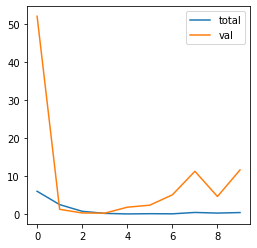

In [170]:
fig, axes = plt.subplots(1, 1, figsize=(4, 4))
axes.plot(loss_log["train"], label="total")
axes.plot(loss_log["val"], label="val")
plt.legend()

・optimizerは tf.train.名Optimizerでインスタンスを作り、optimizer.minimize(目的関数)で最適化をする

・重みの初期化はtf.random_normal

・エポックのループはtensorflowではなく、for文でepoch数だけ回す

他のデータセットへの適用

これまで扱ってきた小さなデータセットがいくつかあります。上記サンプルコードを書き換え、これらに対して学習・推定を行うニューラルネットワークを作成してください。


・Iris（3種類全ての目的変数を使用）
・House Prices

どのデータセットもtrain, val, testの3種類に分けて使用してください。

## 【問題3】3種類全ての目的変数を使用したIrisのモデルを作成

Irisデータセットのtrain.csvの中で、目的変数Speciesに含まれる3種類全てを分類できるモデルを作成してください。


Iris Species


2クラスの分類と3クラス以上の分類の違いを考慮してください。それがTensorFlowでどのように書き換えられるかを公式ドキュメントなどを参考に調べてください。


《ヒント》


以下の2箇所は2クラス分類特有の処理です。

    loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits))
    
    correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))
    
メソッドは以下のように公式ドキュメントを確認してください。


[tf.nn.sigmoid_cross_entropy_with_logits  |  TensorFlow](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits)


[tf.math.sign  |  TensorFlow](https://www.tensorflow.org/api_docs/python/tf/math/sign)


＊tf.signとtf.math.signは同じ働きをします。

In [207]:
from sklearn.preprocessing import OneHotEncoder

# データセットの読み込み
# データフレームから条件抽出
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)

y[y == 'Iris-setosa'] = 0
y[y== 'Iris-versicolor'] = 1
y[y == 'Iris-virginica'] = 2
y = y.astype(np.int)[:, np.newaxis]

#  OneHotEncoder
oe = OneHotEncoder(categories="auto",sparse=False)
y = oe.fit_transform(y)
print(y)
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0.

In [208]:
# ハイパーパラメータの設定
learning_rate = 0.1
batch_size = 10
num_epochs = 10
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1] #特徴量数
n_samples = X_train.shape[0] #サンプル数
n_classes = y_train.shape[1] #クラス数
# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])
# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

In [209]:
def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """
    # 重みとバイアスの宣言
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }
    #全結合層
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
    return layer_output

In [210]:
# ネットワーク構造の読み込み                               
logits = example_net(X)
# 目的関数(変更)
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=logits))
# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)
#推定結果(probability)
proba = tf.nn.softmax(logits)
#推定結果(label)
pred = tf.argmax(proba, axis=1)
# 推定結果(変更)
correct_pred = tf.equal(tf.argmax(Y, axis=1), pred)
# 指標値計算
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
# variableの初期化
init = tf.global_variables_initializer()

In [211]:
# 計算グラフの実行
with tf.Session() as sess:
    #変数を初期化
    sess.run(init)
    # グラフ[]
    loss_log = {"train": [], "val": [], "acc": [], "val_acc": []}
    #エポックごとにループ
    for epoch in range(num_epochs):
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        
        #lossとaccの初期値
        total_loss = 0
        total_acc = 0
        #　ミニバッチごとにループ
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # 誤差を最小にする
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            #　lossとaccuracyを求める
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            print(sess.run(pred, feed_dict={X: mini_batch_x}))
            total_loss += loss
            total_acc += acc
        #　サンプル数で割る
        total_loss /= n_samples
        total_acc /= n_samples
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
        loss_log["train"].append(total_loss)
        loss_log["val"].append(val_loss)
        loss_log["acc"].append(total_acc)
        loss_log["val_acc"].append(val_acc)
    #未知データの推定  
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))

[1 2 2 2 1 2 2 2 1 2]
[2 2 2 2 2 2 2 2 2 2]
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[2 2 2 2 2 2 2 2 2 2]
[2 2 2 2 2 2 2 2 2 2]
[2 2 2 2 2 2 2 2 2 2]
[2 0 2 2 2 2 0 2 0 0]
[2 2 0 0 2 0 0 0 2 0]
[0 1 0 0 1 0]
Epoch 0, loss : 50.2908, val_loss : 94.0595, acc : 0.333, val_acc : 0.458
[1 0 1 1 1 1 0 1 1 0]
[1 1 1 0 0 1 0 1 1 1]
[2 2 0 2 0 0 0 0 2 2]
[2 0 2 0 0 2 0 0 2 0]
[0 2 0 2 2 2 2 2 0 2]
[0 2 2 2 2 2 2 2 0 0]
[2 0 2 2 0 2 0 2 2 0]
[2 0 2 0 2 2 0 2 0 0]
[2 2 2 0 2 0 0 0 2 0]
[0 2 1 1 1 1]
Epoch 1, loss : 0.0000, val_loss : 0.8171, acc : 1.000, val_acc : 0.875
[1 1 1 1 1 1 0 1 1 0]
[1 1 1 0 0 1 1 1 1 1]
[1 1 0 1 1 1 1 1 1 1]
[1 0 1 0 0 1 0 0 1 0]
[0 1 0 1 2 2 2 2 0 1]
[0 2 1 1 2 2 2 2 0 0]
[2 0 2 1 0 2 0 2 1 0]
[2 0 2 1 2 2 0 2 0 0]
[2 2 2 0 2 0 0 0 2 0]
[0 2 2 2 2 1]
Epoch 2, loss : 8.7340, val_loss : 28.0258, acc : 0.500, val_acc : 0.708
[2 1 2 2 1 2 0 2 2 0]
[2 1 2 0 0 2 1 2 2 2]
[2 2 0 2 1 1 1 1 2 2]
[1 0 1 0 0 1 0 0 2 0]
[0 1 0 1 2 2 2 2 0 1]
[0 1 1 1 1 1 2 2 0 0]
[1 0 1 1 0 1 

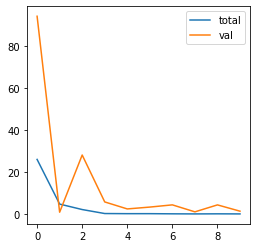

In [212]:
fig, axes = plt.subplots(1, 1, figsize=(4, 4))
axes.plot(loss_log["train"], label="total")
axes.plot(loss_log["val"], label="val")
plt.legend()

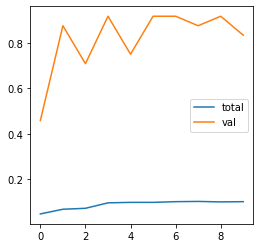

In [213]:
fig, axes = plt.subplots(1, 1, figsize=(4, 4))
axes.plot(loss_log["acc"], label="total")
axes.plot(loss_log["val_acc"], label="val")
plt.legend()

## 【問題4】House Pricesのモデルを作成

*回帰問題*のデータセットであるHouse Pricesを使用したモデルを作成してください。


[House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)


この中のtrain.csvをダウンロードし、目的変数としてSalePrice、説明変数として、GrLivAreaとYearBuiltを使ってください。説明変数はさらに増やしても構いません。


分類問題と回帰問題の違いを考慮してください。



In [123]:
# データセットの読み込み
# データフレームから条件抽出
dataset_path2 ="train.csv"
df = pd.read_csv(dataset_path2)
y = df["SalePrice"]
X = df.loc[:, ["GrLivArea", "YearBuilt"]]
y = np.array(y)
X = np.array(X)
# 次元変換
y = y[:, np.newaxis]
# 対数変換
X = np.log(X)
y = np.log(y)
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [124]:
# ハイパーパラメータの設定
learning_rate = 0.001
batch_size = 20
num_epochs = 20
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1] #特徴量数
n_samples = X_train.shape[0] #サンプル数
n_classes = y_train.shape[1] #クラス数
# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])
# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

In [125]:
def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """
    # 重みとバイアスの宣言
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }
    #全結合層
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
    return layer_output

In [128]:
# ネットワーク構造の読み込み                               
logits = example_net(X)
# 目的関数(変更)
loss_op = tf.reduce_mean(tf.square(Y - logits))
# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)
#推定結果(変更)
pred = logits
# 指標値計算(変更)
mse = tf.reduce_mean(tf.square(Y - pred))
# variableの初期化
init = tf.global_variables_initializer()

In [153]:
# 計算グラフの実行
with tf.Session() as sess:
    #変数を初期化
    sess.run(init)
    # グラフ[]
    loss_log = {"train": [], "val": []}
    #エポックごとにループ
    for epoch in range(num_epochs):
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        #lossの初期値
        total_loss = 0
        #　ミニバッチごとにループ
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # 誤差を最小にする
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            #　lossを求める
            loss = sess.run(loss_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
        #　サンプル数で割る
        total_loss /= n_samples
        val_loss = sess.run(loss_op, feed_dict={X: X_val, Y: y_val})
        loss_log["train"].append(total_loss)
        loss_log["val"].append(val_loss)
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}".format(epoch+1, loss, val_loss))
    #未知データの推定  
    test_mse = sess.run(mse, feed_dict={X: X_test, Y: y_test})
    print("mse : {:.3f}".format(test_mse))

Epoch 1, loss : 640.8104, val_loss : 612.7548
Epoch 2, loss : 32.0607, val_loss : 27.1966
Epoch 3, loss : 28.1027, val_loss : 23.0692
Epoch 4, loss : 24.0875, val_loss : 20.2732
Epoch 5, loss : 18.5248, val_loss : 16.0071
Epoch 6, loss : 15.4008, val_loss : 13.7462
Epoch 7, loss : 12.2115, val_loss : 11.3461
Epoch 8, loss : 9.2890, val_loss : 8.9737
Epoch 9, loss : 6.7814, val_loss : 6.8599
Epoch 10, loss : 4.9944, val_loss : 5.2918
Epoch 11, loss : 3.7699, val_loss : 4.1205
Epoch 12, loss : 2.8761, val_loss : 3.2555
Epoch 13, loss : 2.2071, val_loss : 2.5855
Epoch 14, loss : 1.6819, val_loss : 2.0423
Epoch 15, loss : 1.2736, val_loss : 1.6299
Epoch 16, loss : 1.0070, val_loss : 1.3198
Epoch 17, loss : 0.8162, val_loss : 1.0955
Epoch 18, loss : 0.6877, val_loss : 0.9312
Epoch 19, loss : 0.6023, val_loss : 0.8121
Epoch 20, loss : 0.5470, val_loss : 0.7228
mse : 1.375


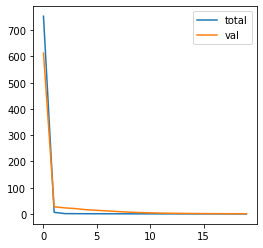

In [154]:
fig, axes = plt.subplots(1, 1, figsize=(4, 4))
axes.plot(loss_log["train"], label="total")
axes.plot(loss_log["val"], label="val")
plt.legend()

## 【問題5】MNISTのモデルを作成

ニューラルネットワークのスクラッチで使用したMNISTを分類するモデルを作成してください。


3クラス以上の分類という点ではひとつ前のIrisと同様です。入力が画像であるという点で異なります。


スクラッチで実装したモデルの再現を目指してください。

In [226]:
from keras.datasets import mnist

#データの読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# print(y_train.shape)
# 次元変換
y_train = y_train.astype(np.int)[:, np.newaxis]
# print(y_train)
y_test = y_test.astype(np.int)[:, np.newaxis]
# print(y_test)
#  OneHotEncoder
oe = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train = oe.fit_transform(y_train)
# print(y_train)
y_test = oe.fit_transform(y_test)
# print(y_test)
#データの変換
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
# print(X_train.shape)
# print(X_test.shape)
#分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
# print(X_train.shape)
# print(X_test.shape)

(60000,)
[[5]
 [0]
 [4]
 ...
 [5]
 [6]
 [8]]
[[7]
 [2]
 [1]
 ...
 [4]
 [5]
 [6]]
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(60000, 784)
(10000, 784)
(48000, 784)
(10000, 784)


In [228]:
# ハイパーパラメータの設定
learning_rate = 0.001
batch_size = 20
num_epochs = 20
n_hidden1 = 50
n_hidden2 = 25
n_input = X_train.shape[1] #特徴量数
n_samples = X_train.shape[0] #サンプル数
n_classes = y_train.shape[1] #クラス数
# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])
# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)
# print(y_train.shape[1])

In [229]:
def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """
    # 重みとバイアスの宣言
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }
    #全結合層
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
    return layer_output

In [230]:
# ネットワーク構造の読み込み                               
logits = example_net(X)
# 目的関数
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=logits))
# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)
#推定結果(probability)
proba = tf.nn.softmax(logits)
#推定結果(label)
pred = tf.argmax(proba, axis=1)
# 推定結果
correct_pred = tf.equal(tf.argmax(Y, axis=1), pred)
# 指標値計算
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
# variableの初期化
init = tf.global_variables_initializer()

In [232]:
# 計算グラフの実行
with tf.Session() as sess:
    #変数を初期化
    sess.run(init)
    # グラフ[]
    loss_log = {"train": [], "val": [], "acc": [], "val_acc": []}
    #エポックごとにループ
    for epoch in range(num_epochs):
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        
        #lossとaccの初期値
        total_loss = 0
        total_acc = 0
        #　ミニバッチごとにループ
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # 誤差を最小にする
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            #　lossとaccuracyを求める
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
        #　サンプル数で割る
        total_loss /= n_samples
        total_acc /= n_samples
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
        loss_log["train"].append(total_loss)
        loss_log["val"].append(val_loss)
        loss_log["acc"].append(total_acc)
        loss_log["val_acc"].append(val_acc)
    #未知データの推定  
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))

Epoch 0, loss : 2.2799, val_loss : 2.3046, acc : 0.150, val_acc : 0.182
Epoch 1, loss : 1.6665, val_loss : 2.0049, acc : 0.400, val_acc : 0.255
Epoch 2, loss : 1.4345, val_loss : 1.8434, acc : 0.450, val_acc : 0.298
Epoch 3, loss : 1.0617, val_loss : 1.5058, acc : 0.600, val_acc : 0.482
Epoch 4, loss : 0.8228, val_loss : 1.2597, acc : 0.600, val_acc : 0.555
Epoch 5, loss : 0.6676, val_loss : 1.1164, acc : 0.650, val_acc : 0.612
Epoch 6, loss : 0.5677, val_loss : 0.9724, acc : 0.750, val_acc : 0.659
Epoch 7, loss : 0.4687, val_loss : 0.8542, acc : 0.800, val_acc : 0.717
Epoch 8, loss : 0.4064, val_loss : 0.7310, acc : 0.800, val_acc : 0.777
Epoch 9, loss : 0.4349, val_loss : 0.6487, acc : 0.750, val_acc : 0.809
Epoch 10, loss : 0.4501, val_loss : 0.5916, acc : 0.750, val_acc : 0.836
Epoch 11, loss : 0.3865, val_loss : 0.5462, acc : 0.850, val_acc : 0.855
Epoch 12, loss : 0.3976, val_loss : 0.4993, acc : 0.850, val_acc : 0.865
Epoch 13, loss : 0.3780, val_loss : 0.4635, acc : 0.850, val_

正解率9割　動くからよし